In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from arbitragelab.hedge_ratios import (construct_spread, get_box_tiao_hedge_ratio,
                                       get_johansen_hedge_ratio, get_minimum_hl_hedge_ratio, 
                                       get_ols_hedge_ratio, get_tls_hedge_ratio,
                                       get_adf_optimal_hedge_ratio)

# Hedge Ratio Methods

In order to test our hedge ratios module, let's first create a spread that is mean-reverting by its nature and see how different methods perform.

In [2]:
# Generating a series of returns X
rs = np.random.RandomState(42)
X_returns = rs.normal(0, 1, 100)
X = pd.Series(np.cumsum(X_returns), name='X') + 50

# And series of cointegrated returns Y
noise = rs.normal(0, 1, 100)
Y = 5 * X + noise
Y.name = 'Y'

cointegrated_series = pd.concat([Y, X], axis=1)

By default, the first columns ticker is used as a **dependent variable**. This can be adjusted in hedge ratio functions by providing an alternative ticker to be used as a dependent variable.

In [3]:
# Check columns in a generated dataframe
cointegrated_series.columns

Index(['Y', 'X'], dtype='object')

In [4]:
# Use the construct_spread function with provided hedge ratios
theoretical_spread = construct_spread(price_data=cointegrated_series,
                                      hedge_ratios={'Y': 1, 'X': 5})

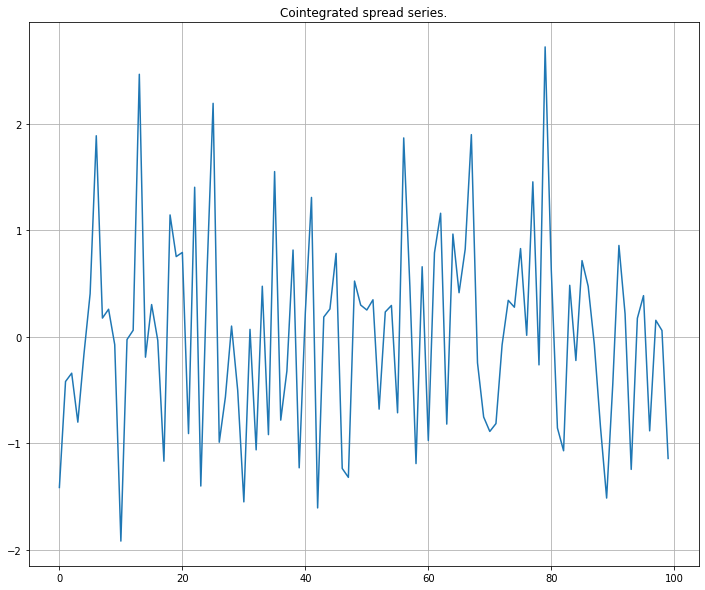

In [5]:
# Plot resulting spread
theoretical_spread.plot(figsize=(12, 10), grid=True, title='Cointegrated spread series.');

One can also decide on `dependent variable` in `construct_spread` function.

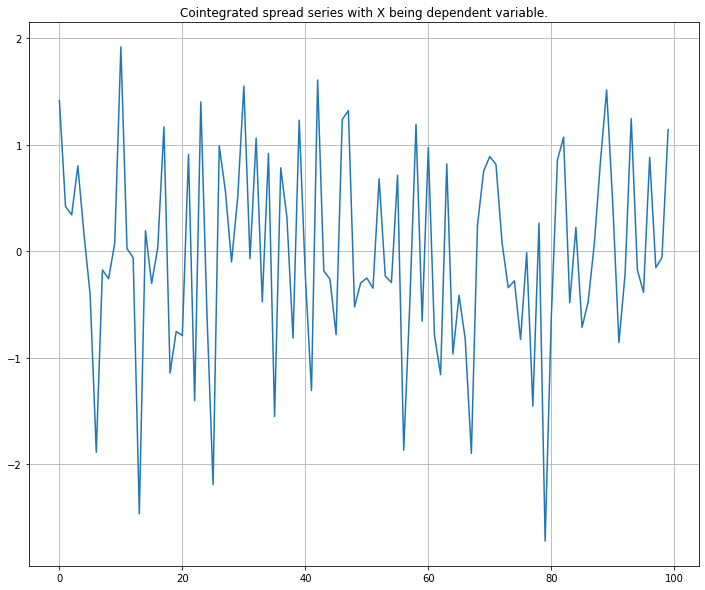

In [6]:
# Spread construction with given dependent variable
theoretical_spread_reverted = construct_spread(price_data=cointegrated_series,
                                               hedge_ratios={'Y': 1, 'X': 5},
                                               dependent_variable='X')

theoretical_spread_reverted.plot(figsize=(12, 10), grid=True, title='Cointegrated spread series with X being dependent variable.');

Now we can compare these spreads and see that one is a reverted version of the other.

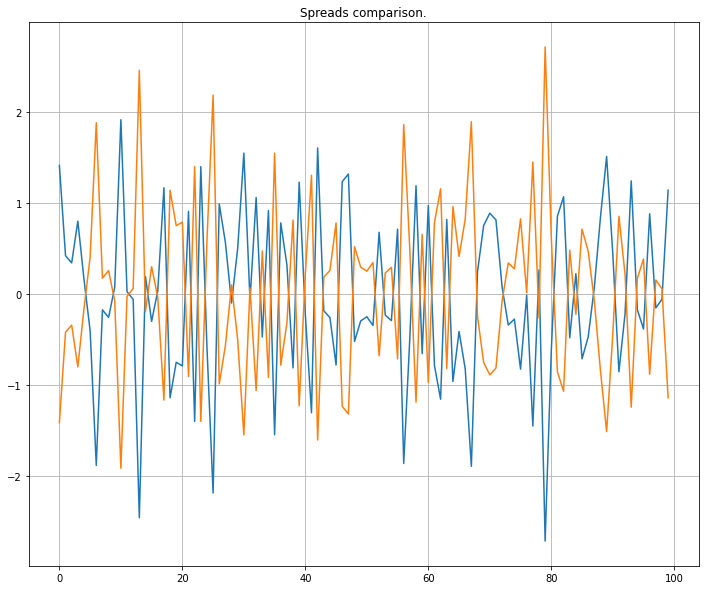

In [7]:
theoretical_spread_reverted.plot(figsize=(12, 10), grid=True, title='Spreads comparison.')
theoretical_spread.plot(figsize=(12, 10), grid=True, title='Spreads comparison.');

In [8]:
# Mean values of two generated spreads
theoretical_spread.mean(), theoretical_spread_reverted.mean()

(0.022304587049924295, -0.022304587049924295)

## OLS and TLS hedge ratios

Now let's use Ordinary Least Squares and Total Least Squares to estimate hedge ratios and see how far the results are from theoretical values.

In [9]:
ols_hedge_ratio, X, y, spread_ols = get_ols_hedge_ratio(price_data=cointegrated_series,
                                                        dependent_variable='Y',
                                                        add_constant=False) # One can add constant if needed.

tls_hedge_ratio, X, y, spread_tls = get_tls_hedge_ratio(price_data=cointegrated_series,
                                                        dependent_variable='Y',
                                                        add_constant=False) # One can add constant if needed.

Hedge ratios methods return:
- Hedge ratio dictionary such that the `dependent variable` has a hedge ratio of 1. 
- X and y datasets used in model valuation. It means that the ratio was found by regressing $y \sim X + eps$.
- Resulting spread obtained by calculated hedge ratio. It can be also obtained by using `contruct_spread` method.
- All hedge ratio and spread calculations assume that: $spread = 1.0*Price_{dependent variable} - hedge_{1}*Price_{1}-...hedge_{n}*Price_{n}$

In [10]:
# Checking hedge reatios for both methods
ols_hedge_ratio, tls_hedge_ratio

({'Y': 1.0, 'X': 5.000487205881515}, {'Y': 1.0, 'X': 5.000577298072243})

As we can see, OLS and TLS managed to capture the hedge ratio correctly.

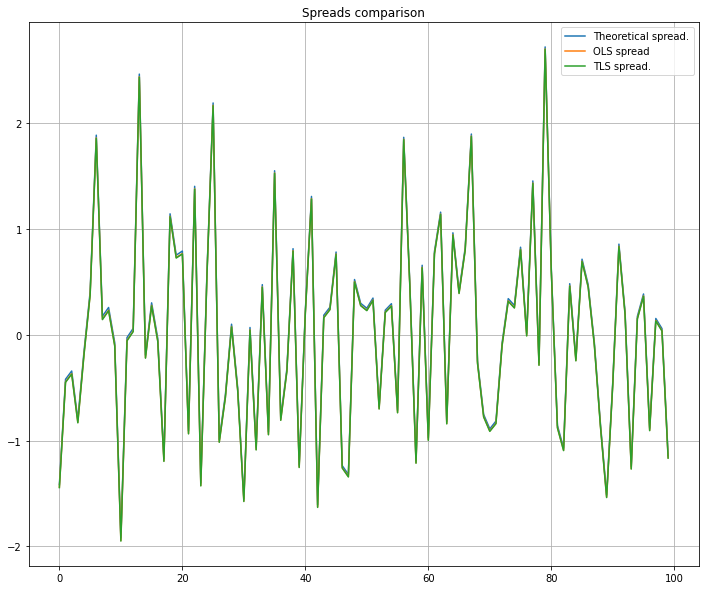

In [11]:
# Plotting theoretical, OLS, and TLS spreads

theoretical_spread.plot(figsize=(12, 10), grid=True, title='Spreads comparison', label='Theoretical spread.')
spread_ols.plot(figsize=(12, 10), grid=True, title='Spreads comparison', label='OLS spread')
spread_tls.plot(figsize=(12, 10), grid=True, title='Spreads comparison', label='TLS spread.')
plt.legend(loc='best');

## Johansen hedge ratio

In [12]:
johansen_hedge_ratio, _, _, spread_joh = get_johansen_hedge_ratio(price_data=cointegrated_series,
                                                                  dependent_variable='Y')

In [13]:
# Checking hedge reatio of the Johansen method
johansen_hedge_ratio

{'Y': 1.0, 'X': 5.001490558510801}

## Box-Tiao hedge ratio

In [14]:
bt_hedge_ratio, _, _, spread_bt = get_box_tiao_hedge_ratio(price_data=cointegrated_series,
                                                           dependent_variable='Y')

In [15]:
# Checking hedge reatio of the Box-Tiao method
bt_hedge_ratio

{'Y': 1.0, 'X': 5.008791156186213}

## Minimum half-life, Minimum ADF t-statistic hedge ratio

Min HL, Min ADF methods use numerical optimization techniques to find a spread with minimum half-life of mean-reversion, minimum ADF
t-statistic, respectively.

In [16]:
min_hl_hedge_ratio, _, _, spread_min_hl, opt_object_hl = get_minimum_hl_hedge_ratio(price_data=cointegrated_series, 
                                                                                    dependent_variable='Y')

min_adf_hedge_ratio, _, _, spread_min_adf, opt_object_adf = get_adf_optimal_hedge_ratio(price_data=cointegrated_series, 
                                                                                        dependent_variable='Y')

In [17]:
# Checking hedge reatio of the Minimum half-life method
min_hl_hedge_ratio

{'Y': 1.0, 'X': 4.999096349068259}

In [18]:
# Checking hedge reatio of the Minimum ADF t-statistic method
min_adf_hedge_ratio

{'Y': 1.0, 'X': 5.002364164524182}

As both methods rely on numerical optimization, sometimes methods fail to converge yielding unstable, wrong results. That is why both methods return scipy optimization objects which can be used to check the status of optimization.

In [19]:
# Optimization status of the Minimum half-life method
opt_object_hl.message

'Optimization terminated successfully.'

In [20]:
# Optimization status of the Minimum ADF t-statistic method
opt_object_adf.message

'Optimization terminated successfully.'

## Example of diverging min HL/ADF hedge ratios

In [21]:
diverging_series = cointegrated_series.copy()

# Creating two constant assets.
diverging_series['Y'] = 1.0
diverging_series['X'] = 2.0

In [22]:
min_hl_hedge_ratio, _, _, spread_min_hl, opt_object_hl = get_minimum_hl_hedge_ratio(price_data=diverging_series, 
                                                                                    dependent_variable='Y')

min_adf_hedge_ratio, _, _, spread_min_adf, opt_object_adf = get_adf_optimal_hedge_ratio(price_data=diverging_series, 
                                                                                        dependent_variable='Y')

/Users/illya/Projects/arbitragelab/arbitragelab/cointegration_approach/signals.py:32: RuntimeWarning: divide by zero encountered in double_scalars
  half_life = -np.log(2) / reg.coef_[0]
/Users/illya/Projects/arbitragelab/arbitragelab/cointegration_approach/signals.py:32: RuntimeWarning: divide by zero encountered in double_scalars
  half_life = -np.log(2) / reg.coef_[0]
/Users/illya/Programs/Anaconda/anaconda3/envs/arblab3.8/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/illya/Projects/arbitragelab/arbitragelab/hedge_ratios/half_life.py:55: UserWarning: Optimization failed to converge. Please check output hedge ratio! The result can be unstable!
  warnings.warn('Optimization failed to converge. Please check output hedge ratio! The result can be unstable!')
/Users/illya/Programs/Anaconda/anaconda3/envs/arblab3.8/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:924: RuntimeWarn

In [23]:
# Optimization status of both methods
opt_object_hl.message, opt_object_adf.message

('NaN result encountered.', 'NaN result encountered.')

## Example on real data

Let's apply functions on a real dataset and construct a spread from 3 assets.

In [24]:
# Loading data
price_data = pd.read_csv('data/data.csv', index_col=0, parse_dates=[0])
price_data = price_data[['GOOG', 'AAPL', 'AMZN']].dropna()

In [25]:
# Calculating hedge ratios using all mehtods

ols_hedge_ratio, _, _, spread_ols = get_ols_hedge_ratio(price_data=price_data, dependent_variable='GOOG', add_constant=False) 
tls_hedge_ratio, _, _, spread_tls = get_tls_hedge_ratio(price_data=price_data, dependent_variable='GOOG', add_constant=False)
joh_hedge_ratio, _, _, spread_joh = get_johansen_hedge_ratio(price_data=price_data, dependent_variable='GOOG')
bt_hedge_ratio, _, _, spread_bt = get_box_tiao_hedge_ratio(price_data=price_data, dependent_variable='GOOG')
min_hl_hedge_ratio, _, _, spread_min_hl, _ = get_minimum_hl_hedge_ratio(price_data=price_data, dependent_variable='GOOG')
min_adf_hedge_ratio, _, _, spread_min_adf, _ = get_adf_optimal_hedge_ratio(price_data=price_data, dependent_variable='GOOG')

/Users/illya/Programs/Anaconda/anaconda3/envs/arblab3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/illya/Projects/arbitragelab/arbitragelab/hedge_ratios/half_life.py:55: UserWarning: Optimization failed to converge. Please check output hedge ratio! The result can be unstable!
  warnings.warn('Optimization failed to converge. Please check output hedge ratio! The result can be unstable!')


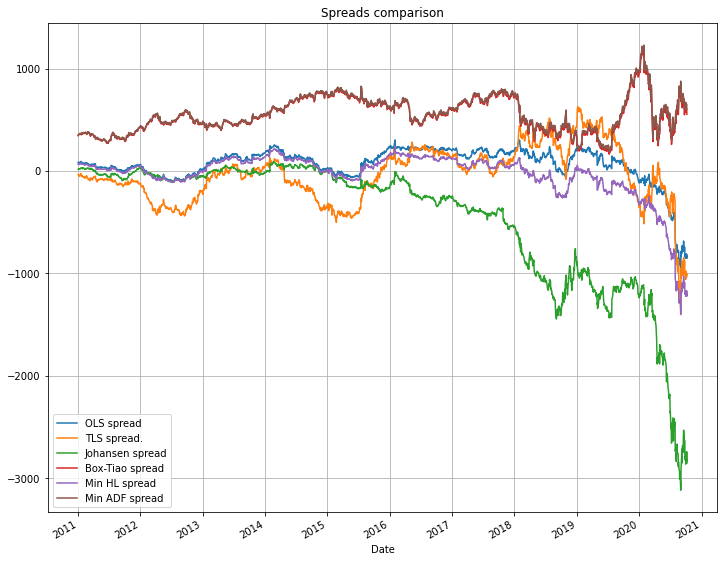

In [26]:
# Plotting spreads from each method
spread_ols.plot(figsize=(12, 10), grid=True, title='Spreads comparison', label='OLS spread')
spread_tls.plot(figsize=(12, 10), grid=True, title='Spreads comparison', label='TLS spread.')
spread_joh.plot(figsize=(12, 10), grid=True, title='Spreads comparison', label='Johansen spread')
spread_bt.plot(figsize=(12, 10), grid=True, title='Spreads comparison', label='Box-Tiao spread')
spread_min_hl.plot(figsize=(12, 10), grid=True, title='Spreads comparison', label='Min HL spread')
spread_min_adf.plot(figsize=(12, 10), grid=True, title='Spreads comparison', label='Min ADF spread')
plt.legend(loc='best');

## Conclusion

This notebook presents the use of the hedge ratios methods available in the MlFinLab package. 

When applied to synthetically generated data, they perform similarly. However, on real data, the results may differ, as methods have different underlying logic.

It should be noted that some methods may fail to converge, and the output may be unstable.